<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2024/blob/main/Module_7/25_QM9_data_parsing_SELFIES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook shows how to extract information from QM9 dataset, particularly from each molecule (given originally in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.



### Notebook prepared by Ayana Ghosh

### Email: research.aghosh@gmail.com

### Link to orginal dataset:

http://quantum-machine.org/datasets/

In [1]:
!pip install tensorflow==2.12;

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 8.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Un

### Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment.

https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html



Install rdkit

In [1]:
!pip install rdkit-pypi
!pip install wget
#!pip install selfies

!pip install selfies --upgrade

Import packages

In [2]:
import numpy as np
import pandas as pd

import glob
import wget

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

import torch
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize

import selfies as sf

Mount Google Drive

In [3]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [4]:
#@title Helper functions for parsing
def parse_float(s: str) -> float:
    try:
        return float(s)
    except ValueError:
        base, power = s.split('*^')
        return float(base) * 10**float(power)


def parse_xyz(filename):
    """
    Parses QM9 specific xyz files.
    :param filename: str path to file
    :return:
    """
    num_atoms = 0
    scalar_properties = []
    atomic_symbols = []
    xyz = []
    charges = []
    harmonic_vibrational_frequencies = []
    smiles = ''
    inchi = ''
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                num_atoms = int(line)
            elif line_num == 1:
                scalar_properties = [float(i) for i in line.split()[2:]]
            elif 2 <= line_num <= 1 + num_atoms:
                atom_symbol, x, y, z, charge = line.split()
                atomic_symbols.append(atom_symbol)
                xyz.append([parse_float(x), parse_float(y), parse_float(z)])
                charges.append(parse_float(charge))
            elif line_num == num_atoms + 2:
                harmonic_vibrational_frequencies = [float(i) for i in line.split()]
            elif line_num == num_atoms + 3:
                smiles = line.split()[0]
            elif line_num == num_atoms + 4:
                inchi = line.split()[0]

    result = {
        'num_atoms': num_atoms,
        'atomic_symbols': atomic_symbols,
        'pos': torch.tensor(xyz),
        'charges': np.array(charges),
        'harmonic_oscillator_frequencies': harmonic_vibrational_frequencies,
        'smiles': smiles,
        'inchi': inchi
    }
    scalar_property_labels = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv']
    scalar_properties = dict(zip(scalar_property_labels, scalar_properties))
    result.update(scalar_properties)
    return result

### Here, we only use 20 molecules form QM9 to show an example.

### Let's download the data

In [5]:
!gdown https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF

Downloading...
From (original): https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF
From (redirected): https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF&confirm=t&uuid=ece89241-99b5-4a07-a678-c4eccd80b226
To: /content/dsgdb9nsd.xyz.tar.bz2
100% 86.1M/86.1M [00:00<00:00, 234MB/s]


In [6]:
#!wget -O QM9_molecules.zip https://www.dropbox.com/scl/fi/efc5fa4mqex3t2xa0zvi5/QM9_molecules.zip?rlkey=i47z08elmeach0xrkh32ukafo&dl=0
#!unzip QM9_molecules.zip -d '/content/drive/MyyDrive/'

Generate lists of SMILE strings and append with properties that we can directly retrieve from the QM9 dataset

In [7]:
# prompt: create folde rMolecules and unzip /content/dsgdb9nsd.xyz.tar.bz2 into folder Molecules

!mkdir /content/Molecules
!tar -C Molecules -xvf /content/dsgdb9nsd.xyz.tar.bz2

Streaming output truncated to the last 5000 lines.
dsgdb9nsd_128886.xyz
dsgdb9nsd_128887.xyz
dsgdb9nsd_128888.xyz
dsgdb9nsd_128889.xyz
dsgdb9nsd_128890.xyz
dsgdb9nsd_128891.xyz
dsgdb9nsd_128892.xyz
dsgdb9nsd_128893.xyz
dsgdb9nsd_128894.xyz
dsgdb9nsd_128895.xyz
dsgdb9nsd_128896.xyz
dsgdb9nsd_128897.xyz
dsgdb9nsd_128898.xyz
dsgdb9nsd_128899.xyz
dsgdb9nsd_128900.xyz
dsgdb9nsd_128901.xyz
dsgdb9nsd_128902.xyz
dsgdb9nsd_128903.xyz
dsgdb9nsd_128904.xyz
dsgdb9nsd_128905.xyz
dsgdb9nsd_128906.xyz
dsgdb9nsd_128907.xyz
dsgdb9nsd_128908.xyz
dsgdb9nsd_128909.xyz
dsgdb9nsd_128910.xyz
dsgdb9nsd_128911.xyz
dsgdb9nsd_128912.xyz
dsgdb9nsd_128913.xyz
dsgdb9nsd_128914.xyz
dsgdb9nsd_128915.xyz
dsgdb9nsd_128916.xyz
dsgdb9nsd_128917.xyz
dsgdb9nsd_128918.xyz
dsgdb9nsd_128919.xyz
dsgdb9nsd_128920.xyz
dsgdb9nsd_128921.xyz
dsgdb9nsd_128922.xyz
dsgdb9nsd_128923.xyz
dsgdb9nsd_128924.xyz
dsgdb9nsd_128925.xyz
dsgdb9nsd_128926.xyz
dsgdb9nsd_128927.xyz
dsgdb9nsd_128928.xyz
dsgdb9nsd_128929.xyz
dsgdb9nsd_128930.xyz
dsgd

In [8]:
# prompt: Unzip the file /content/QM9_molecules.zip

#!unzip /content/QM9_molecules.zip

In [9]:
smiles = []
enthalpy = []
u0 = []
u = []
g = []
alpha = []
r2 = []
mu = []

#may need to change the path
filenames = glob.glob('/content/Molecules/*.xyz')

#may need to go through the full range
for fid in range(5000):
    x = parse_xyz(filenames[fid])
    smiles_loc = x['smiles']
    enthalpy_loc = x['h']
    dipole_moment = x['mu']
    homo_loc = x['homo']
    lumo_loc = x['lumo']
    gap_loc = x['gap']
    zpve_loc = x['zpve']
    u0_loc = x['u0']
    u_loc = x['u']
    g_loc = x['g']
    alpha_loc = x['alpha']
    r2_loc = x['r2']
    smiles.append(smiles_loc)
    mu.append(dipole_moment)
    enthalpy.append(enthalpy_loc)
    u0.append(u0_loc)
    u.append(u_loc)
    g.append(g_loc)
    alpha.append(alpha_loc)
    r2.append(r2_loc)

Let's compute few basic features and put together a dataset.

Features we compute:
molecular weight, topological polar surface area, molar log P,
number of hydrogen bond donors, acceptors, valence electrons, maximum partial charge, minimum partial charge, number of rotatable bonds, number of ring counts, number of stereocenters

In [10]:
mol_wt, tpsa, logp_ml, hbd, hba  = [], [], [], [], []
vale, partialcg_max, partialcg_min, rotbd, ringct, stereoct = [], [], [], [], [], []

for i in range(len(smiles)):
    m = Chem.MolFromSmiles(smiles[i])
    mol_wt_l = Descriptors.ExactMolWt(m)
    tpsa_l, logp_l = Descriptors.TPSA(m), Descriptors.MolLogP(m)
    hbd_l, hba_l = Descriptors.NumHDonors(m), Descriptors.NumHAcceptors(m)
    vale_l = Descriptors.NumValenceElectrons(m),
    partialcharge_max_l, partialcharge_min_l = Descriptors.MaxPartialCharge(m), Descriptors.MinPartialCharge(m)
    rotbd_l = Descriptors.NumRotatableBonds(m)
    ring_ct, stereo_cent = Descriptors.RingCount(m), rdMolDescriptors.CalcNumAtomStereoCenters(m)

    mol_wt.append(mol_wt_l)
    tpsa.append(tpsa_l)
    logp_ml.append(logp_l)
    hbd.append(hbd_l)
    hba.append(hba_l)
    vale.append(vale_l)
    partialcg_max.append(partialcharge_max_l)
    partialcg_min.append(partialcharge_min_l)
    rotbd.append(rotbd_l)
    ringct.append(ring_ct)
    stereoct.append(stereo_cent)

New dataset with few features with SMILE strings

In [11]:
df = pd.DataFrame({'smiles': smiles, 'mole_logp': logp_ml,'tpsa': tpsa, 'mol_wt' : mol_wt,
                   'hbd': hbd, 'hba':hba, 'valencee':vale, 'max_partialcharge':partialcg_max, 'min_partialcharge':partialcg_min,
                   'rotatablebd':rotbd, 'ringct':ringct, 'stereocent': stereoct, 'dipole_moment':mu})

In [12]:
df

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
0,N=C1C=NC=NC=N1,-0.64893,62.52,108.043596,1,4,"(40,)",0.164330,-0.281531,0,1,0,1.0626
1,CC(C)(C)CC(O)C#C,1.41670,20.23,126.104465,1,1,"(52,)",0.114506,-0.380374,1,0,1,1.2217
2,CC1(C)OCCC(=N)O1,1.13667,42.31,129.078979,1,3,"(52,)",0.205767,-0.450254,0,1,0,2.3008
3,CNC(=O)OCCC=O,-0.06860,55.40,131.058243,1,3,"(52,)",0.406375,-0.449114,3,0,0,3.7564
4,CC(=N)OC1=NC=CN1,0.78567,61.76,125.058912,2,3,"(48,)",0.299649,-0.411619,1,1,0,4.5187
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CC12CC(N1)C2(N)C#N,-0.65832,61.84,123.079647,2,3,"(48,)",0.137365,-0.310524,0,3,3,3.8670
4996,CC1OC23CN(C2)C13,-0.15830,12.47,111.068414,0,2,"(44,)",0.111809,-0.365881,0,4,2,0.5738
4997,C#CC1(CC1)C1COC1,1.04620,9.23,122.073165,0,1,"(48,)",0.053060,-0.380577,1,2,0,2.2677
4998,OC1C2OCC=CC12,-0.06790,29.46,112.052429,1,2,"(44,)",0.093272,-0.389674,0,2,3,2.0792


In [13]:
df.tail(5)

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
4995,CC12CC(N1)C2(N)C#N,-0.65832,61.84,123.079647,2,3,"(48,)",0.137365,-0.310524,0,3,3,3.8670
4996,CC1OC23CN(C2)C13,-0.15830,12.47,111.068414,0,2,"(44,)",0.111809,-0.365881,0,4,2,0.5738
4997,C#CC1(CC1)C1COC1,1.04620,9.23,122.073165,0,1,"(48,)",0.053060,-0.380577,1,2,0,2.2677
4998,OC1C2OCC=CC12,-0.06790,29.46,112.052429,1,2,"(44,)",0.093272,-0.389674,0,2,3,2.0792
4999,CC(=O)NC(CO)C=O,-1.31770,66.40,131.058243,2,3,"(52,)",0.217023,-0.393771,3,0,1,1.0412


Convert SMILEs to SELFIEs

In [14]:
smiles

['N=C1C=NC=NC=N1',
 'CC(C)(C)CC(O)C#C',
 'CC1(C)OCCC(=N)O1',
 'CNC(=O)OCCC=O',
 'CC(=N)OC1=NC=CN1',
 'CN=COC1CC1C#C',
 'O=C1C2C3NC1C1C3N21',
 'CNC1C(N)C1(N)C#N',
 'C1OC11C2NC1C21CO1',
 'CC1=CC=CC(=O)N1',
 'N=C(CC1CO1)OC=O',
 'FC(F)(F)C1OC1C#N',
 'O=COC1=COC=C1',
 'CCOC1C2OC(=N)C12',
 'O=CC12CC1CCCO2',
 'CC1COCC1CC=O',
 'CC1CC1OCCC#C',
 'CCC1=CN=COC1=O',
 'CC1COC1C1CCC1',
 'O=CCC(OC=O)C#C',
 'CC1OC2C3CC2(C3)O1',
 'CC#CC1=CCCC1C',
 'CC1C=CC(O)C11CN1',
 'OC1=NC=C(C=N1)C#C',
 'OCCC1CC1N1CC1',
 'CC1OC1C12CN(C1)C2',
 'CC1C2CC1(C)C21CN1',
 'CN(C)C1=C(N)N=NO1',
 'CCC1C=CCC1C=O',
 'O=C1CN=C2OCCC12',
 'CC(C)C1OC1C(C)=O',
 'CN(C)C1=NOC(=O)O1',
 'OCC1=CCOC1C=O',
 'OC1CCC2CC2C1=O',
 'CN=C(C)OC(C)=O',
 'O=C1CCCC(=O)C1=O',
 'CC[NH2+]CC(C)C([O-])=O',
 'NC1=CC(=CN1)C1CN1',
 'FC(F)(F)CC#C',
 'COCC1=C(C)C=CN1',
 'CC1(O)C2CC(=O)C1O2',
 'O=CC1C2C=CC(=O)C12',
 'C1OC2CN=COC12',
 'CCOC(C#N)C(C)N',
 'CC1=C(O)C=C(N)N1',
 'N=C1CN2N=CC=C2O1',
 'CC1CCC(O)C1O',
 'CCOC1CC(O)C=C1',
 'OC(C#N)C1(O)CC1O',
 'OC12CC3CC1C2

In [15]:
'''
#list of SMILES and list of correponding SELFIES
selfies_dataset = []

for i in range(len(smiles)):
  local_sf = sf.encoder(smiles[i])
  selfies_dataset.append(local_sf)
  '''

'\n#list of SMILES and list of correponding SELFIES\nselfies_dataset = []\n\nfor i in range(len(smiles)):\n  local_sf = sf.encoder(smiles[i])\n  selfies_dataset.append(local_sf)\n  '

In [16]:
selfies_dataset = []

for i in range(len(smiles)):
    try:
        local_sf = sf.encoder(smiles[i])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        continue  # Skip to the next iteration

Error encoding SMILES at index 1323: input violates the currently-set semantic constraints
	SMILES: CC1=C(C=CO1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2116: input violates the currently-set semantic constraints
	SMILES: OC1=COC(=N1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 4943: input violates the currently-set semantic constraints
	SMILES: NC1=C(C=CN1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]



In [17]:
print(selfies_dataset)

['[N][=C][C][=N][C][=N][C][=N][Ring1][#Branch1]', '[C][C][Branch1][C][C][Branch1][C][C][C][C][Branch1][C][O][C][#C]', '[C][C][Branch1][C][C][O][C][C][C][=Branch1][C][=N][O][Ring1][Branch2]', '[C][N][C][=Branch1][C][=O][O][C][C][C][=O]', '[C][C][=Branch1][C][=N][O][C][=N][C][=C][N][Ring1][Branch1]', '[C][N][=C][O][C][C][C][Ring1][Ring1][C][#C]', '[O][=C][C][C][N][C][Ring1][Branch1][C][C][Ring1][Branch1][N][Ring1][#Branch1][Ring1][Ring1]', '[C][N][C][C][Branch1][C][N][C][Ring1][Ring2][Branch1][C][N][C][#N]', '[C][O][C][Ring1][Ring1][C][N][C][Ring1][Ring2][C][Ring1][Ring2][C][O][Ring1][Ring1]', '[C][C][=C][C][=C][C][=Branch1][C][=O][N][Ring1][#Branch1]', '[N][=C][Branch1][#Branch1][C][C][C][O][Ring1][Ring1][O][C][=O]', '[F][C][Branch1][C][F][Branch1][C][F][C][O][C][Ring1][Ring1][C][#N]', '[O][=C][O][C][=C][O][C][=C][Ring1][Branch1]', '[C][C][O][C][C][O][C][=Branch1][C][=N][C][Ring1][=Branch1][Ring1][Branch1]', '[O][=C][C][C][C][Ring1][Ring1][C][C][C][O][Ring1][#Branch1]', '[C][C][C][O][C]

In [18]:
#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

In [19]:
np.array(one_hot_vectors).shape

(4997, 21, 27)

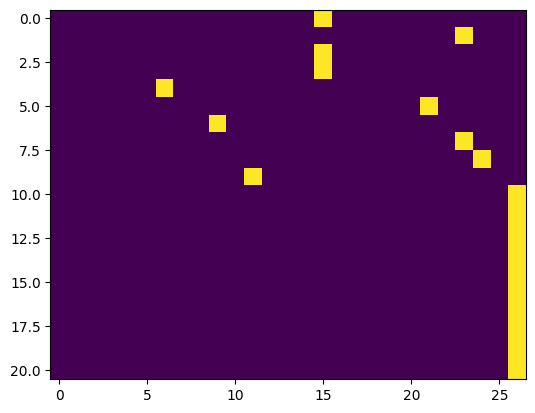

In [20]:
plt.imshow(np.array(one_hot_vectors)[310,:,:])

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

# Define parameters
input_shape = (21, 27)
original_dim = np.prod(input_shape)
latent_dim = 2

# Encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = Flatten()(inputs)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Latent space (sampling layer)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(128, activation='relu')(latent_inputs)
x = Dense(original_dim, activation='sigmoid')(x)
outputs = Reshape(input_shape)(x)

# Instantiate the encoder and decoder models separately
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE Model
vae_outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, vae_outputs, name='vae')

# VAE Loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(vae_outputs)) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Summaries of the models
encoder.summary()
decoder.summary()
vae.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 21, 27)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 567)          0           ['encoder_input[0][0]']          
                                                                                                  
 dense (Dense)                  (None, 128)          72704       ['flatten[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            258         ['dense[0][0]']                  
                                                                                            

In [22]:
data = np.array(one_hot_vectors)
vae.fit(data, epochs=100, batch_size=64)

Epoch 1/100
79/79 [==============================] - 2s 6ms/step - loss: 185.5056
Epoch 2/100
79/79 [==============================] - 1s 7ms/step - loss: 54.8008
Epoch 3/100
79/79 [==============================] - 0s 6ms/step - loss: 48.2885
Epoch 4/100
79/79 [==============================] - 1s 7ms/step - loss: 45.9469
Epoch 5/100
79/79 [==============================] - 0s 6ms/step - loss: 44.5354
Epoch 6/100
79/79 [==============================] - 1s 6ms/step - loss: 42.9949
Epoch 7/100
79/79 [==============================] - 0s 6ms/step - loss: 41.7366
Epoch 8/100
79/79 [==============================] - 1s 8ms/step - loss: 40.9470
Epoch 9/100
79/79 [==============================] - 1s 9ms/step - loss: 40.2919
Epoch 10/100
79/79 [==============================] - 1s 11ms/step - loss: 39.8340
Epoch 11/100
79/79 [==============================] - 1s 11ms/step - loss: 39.3846
Epoch 12/100
79/79 [==============================] - 1s 11ms/step - loss: 39.1717
Epoch 13/100
79/79 [=

In [23]:
def plot_latent_representation(decoder, height=21, width=27, n=15):
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)
    figure = np.zeros((height * n, width * n))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(height, width)
            figure[i * height: (i + 1) * height, j * width: (j + 1) * width] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.axis('off')
    plt.show()


In [24]:
def plot_latent_space(encoder, data):
    z_mean, _, _ = encoder.predict(data);
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.title('Latent Space')
    plt.show()


1/1 [==============================] - 0s 29ms/step


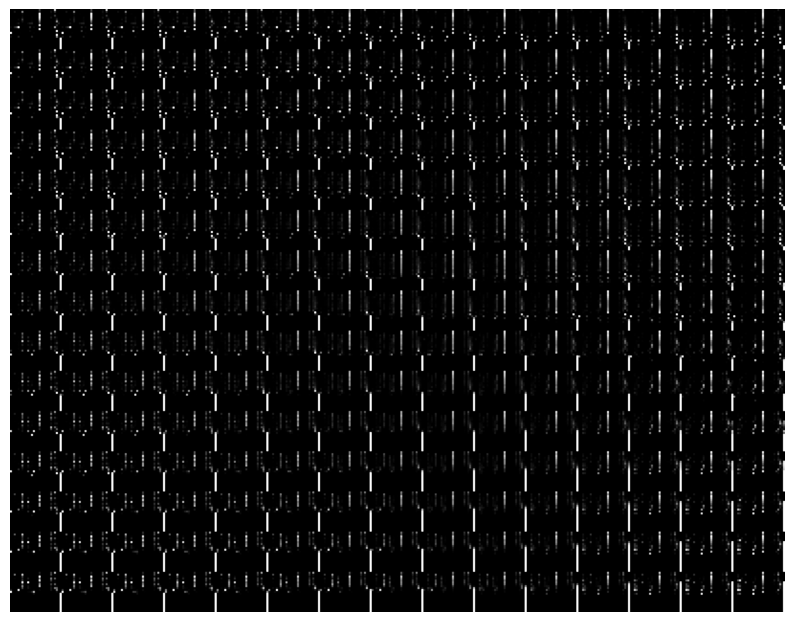

In [25]:
plot_latent_representation(decoder)

157/157 [==============================] - 0s 2ms/step


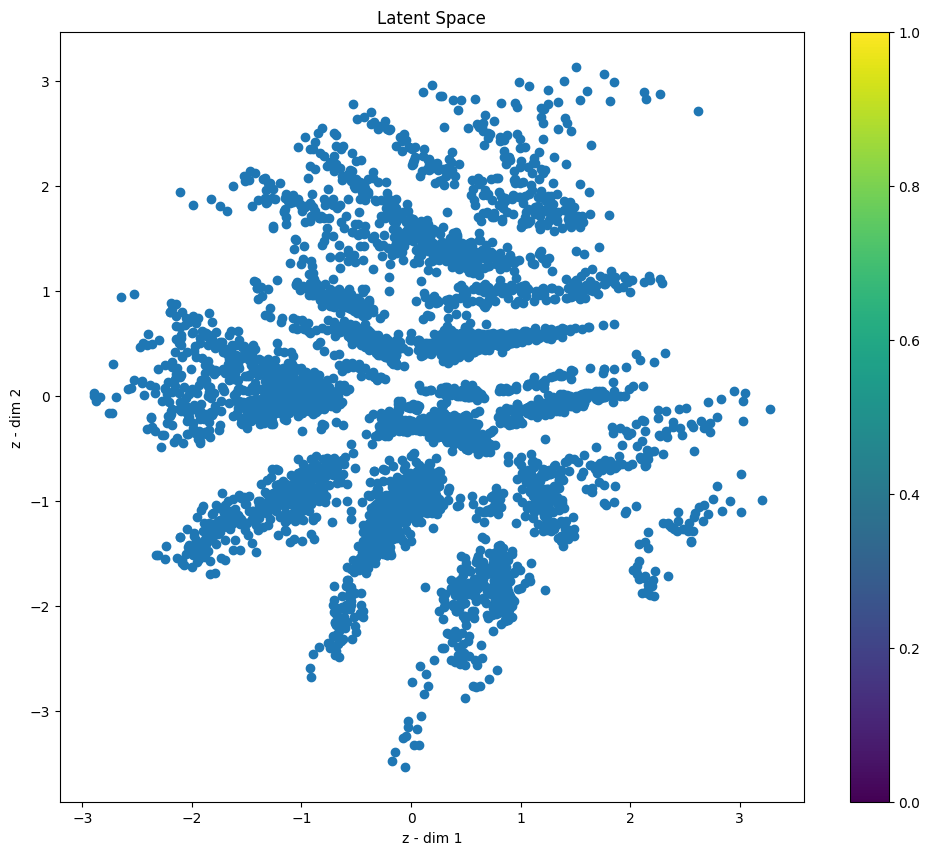

In [26]:
plot_latent_space(encoder, data)